In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set( style="ticks" )

In [2]:
df_train = pd.read_csv("data/3_training_set_day2.csv", index_col=0)
df_test = pd.read_csv("data/4_testing_set_day2.csv", index_col=0)

train_x = df_train.drop(columns=['PRED_1', 'PRED_2'])
train_y = df_train[['PRED_1', 'PRED_2']]

test_x = df_test.drop(columns=['PRED_1', 'PRED_2'])
test_y = df_test[['PRED_1', 'PRED_2']]

In [3]:
pred = np.loadtxt("results/7_lstm_day2.csv", delimiter=',')

In [4]:
print(pred[:,0])

[154.68866723 156.34165386 155.44662159 154.55184527 153.84917312
 154.7797799  155.42117522 156.63830467 154.35068622 154.23697593
 152.82521374 153.63104951 153.50995128 153.25423135 152.02612322
 152.77160938 153.21219898 153.31620912]


MSE: 0.027557953801414407
MAE: 0.030298671062312797


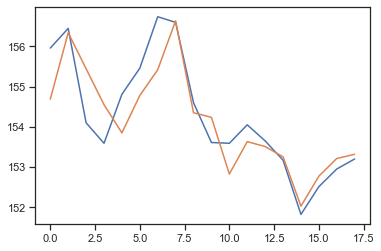

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

l = len(pred)
x = np.arange(0, l)

y_true = []
y_pred = []

for idx in range( l ):
  y_true.append( test_y.iloc[idx][0] )
  #y_pred.append( clf.predict( test_x.iloc[idx].values.reshape(1, -1))[0] )
  y_pred = pred[:,0]
  

fig, ax = plt.subplots()
sns.lineplot(x=x, y=y_true, ax=ax)
sns.lineplot(x=x, y=y_pred, ax=ax)

print(f"MSE: {mean_squared_error(y_true, y_pred) / len(y_true)}") 
print(f"MAE: {mean_absolute_error(y_true, y_pred) / len(y_true)}") 

MSE: 0.09143801932406355
MAE: 0.05968796245203421


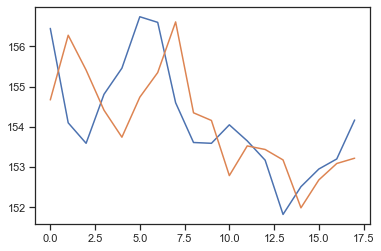

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

l = len(pred)
x = np.arange(0, l)

y_true = []
y_pred = []

for idx in range( l ):
  y_true.append( test_y.iloc[idx][1] )
  #y_pred.append( clf.predict( test_x.iloc[idx].values.reshape(1, -1))[0] )
  y_pred = pred[:,1]
  

fig, ax = plt.subplots()
sns.lineplot(x=x, y=y_true, ax=ax)
sns.lineplot(x=x, y=y_pred, ax=ax)

print(f"MSE: {mean_squared_error(y_true, y_pred) / len(y_true)}") 
print(f"MAE: {mean_absolute_error(y_true, y_pred) / len(y_true)}") 

MSE: 0.1111111111111111
MAE: 0.05555555555555555
accu: 0.5
recall: 0.0


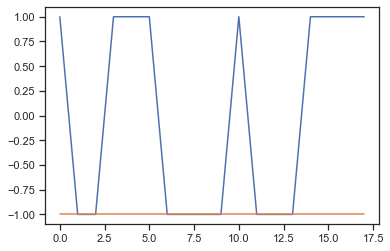

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, recall_score

l = len(pred)
x = np.arange(0, l)

y_true = []
y_pred = []

for idx in range( l ):
  y_true.append( test_y.iloc[idx][1] - test_y.iloc[idx][0] )
  #y_pred.append( clf.predict( test_x.iloc[idx].values.reshape(1, -1))[0] )
  y_pred = pred[:,1] - pred[:,0]
  
for i in range(len(y_true)):
  if y_true[i] > 0:
    y_true[i] = 1
  else:
    y_true[i] = -1

  if y_pred[i] > 0:
    y_pred[i] = 1
  else:
    y_pred[i] = -1

fig, ax = plt.subplots()
sns.lineplot(x=x, y=y_true, ax=ax)
sns.lineplot(x=x, y=y_pred, ax=ax)

print(f"MSE: {mean_squared_error(y_true, y_pred) / len(y_true)}") 
print(f"MAE: {mean_absolute_error(y_true, y_pred) / len(y_true)}") 

print(f"accu: {accuracy_score(y_true, y_pred)}")
print(f"recall: {recall_score(y_true, y_pred)}")

In [22]:
status_now = 0      # {0 : None}, {1 : Have 1}, {-1 : Short 1}
command = []

threshold = 0.0002
# ------- Start predict and command ------- #
for i in range( len( y_pred ) ):
    # Step 1: Predict tomorrow's stock price
    # Step 2: Check whether it will be go up/down with Step1's result
    if (pred[i,1] - pred[i,0]) / pred[i,0] > threshold:      # go up
        if status_now == 0:
            command.append(1)
            status_now = 1
        elif status_now == 1:
            command.append(0)
            status_now = 1
        elif status_now == -1:
            command.append(1)
            status_now = 0
    elif (pred[i,1] - pred[i,0]) / pred[i,0] < -threshold:      # go down
        if status_now == 0:
            command.append(-1)
            status_now = -1
        elif status_now == 1:
            command.append(-1)
            status_now = 0
        elif status_now == -1:
            command.append(0)
            status_now = -1
    else:
        command.append(0)
    
    #print((pred[i,1] - pred[i,0]) / pred[i,0])
    #print(f"Step {i}, y_pred {y_pred[i]}, cmd {command[i]}, status {status_now}")

status_market = 0
profit = 0
for i in range( len( command ) - 1 ):
    if command[i] == 0:
        pass
    elif command[i] == 1:
        if status_market == 0:
            profit -= test_x['A'][i+1]
            status_market = 1
        elif status_market == 1:
            print("error")
        elif status_market == -1:
            profit -= test_x['A'][i+1]
            status_market = 0
    elif command[i] == -1:
        if status_market == 0:
            profit += test_x['A'][i+1]
            status_market = -1
        elif status_market == 1:
            profit += test_x['A'][i+1]
            status_market = 0
        elif status_market == -1:
            print("error")
    
    print(f"Step {i}: cmd:{command[i]} Profit {profit}")

if status_market == 1:
    profit += test_x['A'][17]
elif status_market == -1:
    profit -= test_x['A'][17]

print("Baseline profit: ", test_x['A'][len(test_x)-1] - test_x['A'][0])
print("Total profit: ", profit)


Step 0: cmd:0 Profit 0
Step 1: cmd:-1 Profit 156.45
Step 2: cmd:0 Profit 156.45
Step 3: cmd:0 Profit 156.45
Step 4: cmd:0 Profit 156.45
Step 5: cmd:0 Profit 156.45
Step 6: cmd:0 Profit 156.45
Step 7: cmd:0 Profit 156.45
Step 8: cmd:0 Profit 156.45
Step 9: cmd:0 Profit 156.45
Step 10: cmd:0 Profit 156.45
Step 11: cmd:0 Profit 156.45
Step 12: cmd:0 Profit 156.45
Step 13: cmd:0 Profit 156.45
Step 14: cmd:0 Profit 156.45
Step 15: cmd:0 Profit 156.45
Step 16: cmd:0 Profit 156.45
Baseline profit:  -1.450000000000017
Total profit:  3.5


MSE: 0.11419753086419752
MAE: 0.05864197530864198
accu: 0.4444444444444444


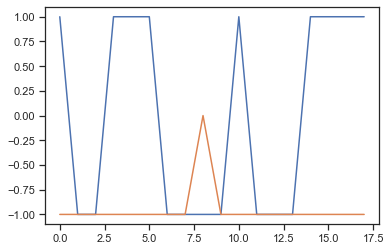

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, recall_score

l = len(pred)
x = np.arange(0, l)

y_true = []
y_pred = []
thd = 0.0001

for idx in range( l ):
  y_true.append( (test_y.iloc[idx][1] - test_y.iloc[idx][0]) / test_y.iloc[idx][0] )
  #y_pred.append( clf.predict( test_x.iloc[idx].values.reshape(1, -1))[0] )
  y_pred = (pred[:,1] - pred[:,0]) / pred[:,0]
  
for i in range(len(y_true)):
  if y_true[i] > thd:
    y_true[i] = 1
  elif y_true[i] < -thd:
      y_true[i] = -1
  else:
    y_true[i] = 0

  if y_pred[i] > thd:
    y_pred[i] = 1
  elif y_pred[i] < -thd:
      y_pred[i] = -1
  else:
    y_pred[i] = 0

fig, ax = plt.subplots()
sns.lineplot(x=x, y=y_true, ax=ax)
sns.lineplot(x=x, y=y_pred, ax=ax)

print(f"MSE: {mean_squared_error(y_true, y_pred) / len(y_true)}") 
print(f"MAE: {mean_absolute_error(y_true, y_pred) / len(y_true)}") 

print(f"accu: {accuracy_score(y_true, y_pred)}")
#print(f"recall: {recall_score(y_true, y_pred)}")